In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reading csv
PE = pd.read_csv("./Data/sp-500-pe-ratio-price-to-earnings-chart.csv", skiprows=15)
Yields = pd.read_csv("./Data/DGS10.csv")
SP500 = pd.read_csv("./Data/SP500.csv")
SP500 = SP500.iloc[:,:2]
PE["inverse"] = 1/PE[' value']

In [3]:
# Rename SP500
SP500.columns = ["date", "SP500"]

# Convert to datatime
PE['date'] = pd.to_datetime(PE['date'])
Yields['observation_date'] = pd.to_datetime(Yields['observation_date'])
SP500['date'] = pd.to_datetime(SP500['date'])

# Get subset of PE
PE = PE[409:].copy()

# Yields
Yields.columns = ["date", "DGS10"]

# Merge the datasets on Year and Month
merged_df = PE.merge(Yields, on=["date"], how="left").copy()
merged_df = merged_df.merge(SP500, on=["date"], how="left").copy()

# Fill na
merged_df['DGS10'] = merged_df['DGS10'].interpolate(method='linear')
merged_df['DGS10'] = merged_df['DGS10'].fillna(method='bfill')
merged_df['DGS10'] = merged_df['DGS10']/100

# ZCB
merged_df['ZCB_cont'] = np.exp(-merged_df['DGS10']*10)
merged_df['ZCB'] = 1/((1 + merged_df['DGS10'])**10)
merged_df['ZCB_seasoned'] = None
merged_df['ZCB_seasoned'][1:] = 1/((1 + merged_df['DGS10'][:-1])**(9 + 11/12))

# Set the spread
merged_df['spread'] = merged_df['inverse'] - merged_df['DGS10']

# Drop the nan values
merged_df = merged_df.dropna().copy()

/var/folders/wm/41byc5p54bldbc8vsyvc3mg80000gn/T/ipykernel_51077/3206439776.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['ZCB_seasoned'][1:] = 1/((1 + merged_df['DGS10'][:-1])**(9 + 11/12))


Plot of the series.

In [4]:
merged_df

,date,value,inverse,DGS10,SP500,ZCB_cont,ZCB,ZCB_seasoned,spread
1,1962-01-01,20.4273,0.048954,0.04090,56.170000,0.664314,0.669746,0.671987,0.008054
2,1962-02-01,20.7596,0.048170,0.04090,70.220000,0.664314,0.669746,0.671987,0.007270
3,1962-03-01,20.6380,0.048454,0.03980,70.290000,0.671662,0.676865,0.671987,0.008654
4,1962-04-01,18.8012,0.053188,0.03915,68.050000,0.676042,0.681111,0.67907,0.014038
5,1962-05-01,17.1844,0.058192,0.03850,62.990000,0.680451,0.685386,0.683294,0.019692
...,...,...,...,...,...,...,...,...,...
797,2023-05-01,23.0917,0.043306,0.03590,4146.173182,0.698374,0.702784,0.690838,0.007406
798,2023-06-01,24.5864,0.040673,0.03610,4345.372857,0.696979,0.701428,0.704852,0.004573
799,2023-07-01,24.9062,0.040151,0.03830,4508.075500,0.681813,0.686707,0.703504,0.001851
800,2023-08-01,24.4649,0.040875,0.04050,4457.358696,0.666977,0.672325,0.688861,0.000375


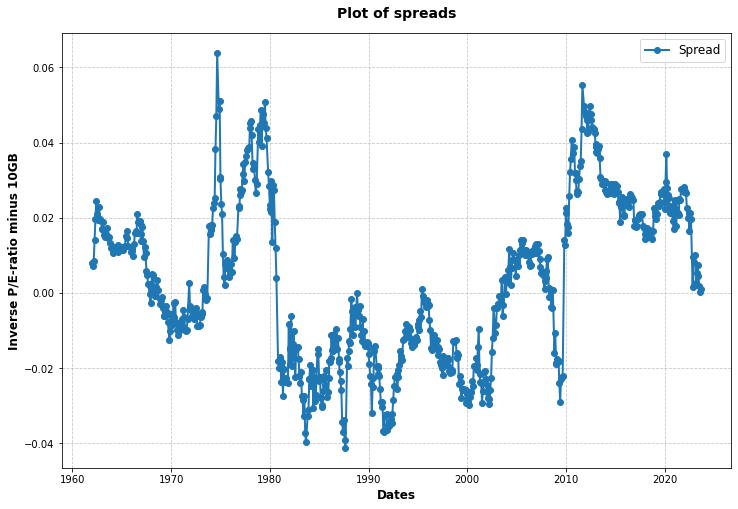

In [7]:
# Set x and y
x = merged_df['date']
y = merged_df['spread']

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with enhanced styling
ax.plot(x, y, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=6, label="Spread")

# Improve aesthetics
ax.set_xlabel('Dates', fontsize=12, fontweight='bold')
ax.set_ylabel('Inverse P/E-ratio minus 10GB', fontsize=12, fontweight='bold')
ax.set_title('Plot of spreads', fontsize=14, fontweight='bold', pad=15)

# Add legend with a styled frame
ax.legend(frameon=True, fontsize=12)

# Add subtle grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Show the plot
plt.show()

Let's code a trading strategy that places $\alpha$ in SP500 and $1 - \alpha$ in 10GB.

In [259]:
# Contruct an alpha array
alpha = np.ones(merged_df.shape[0] - 1)

# Regular returns
spreads = merged_df['spread'].to_numpy()
SP500_numbers = merged_df['SP500'].to_numpy()
bonds_numbers = merged_df['ZCB'].to_numpy()
seasoned_bonds_numbers = merged_df['ZCB_seasoned'].to_numpy()

# Define a function to take spread and return a weight
def compute_alpha(params, spreads=spreads):
    
    if len(params) == 5:
        a = params[0]
        b = params[1]
        c = params[2]
        d = params[3]
        e = params[4]
        return 1 / (1 + np.exp(-(a + b*spreads + c*(spreads**2) + d*(spreads**3) + e*(spreads**4))))
    
    if len(params) == 4:
        a = params[0]
        b = params[1]
        c = params[2]
        d = params[3]
        return 1 / (1 + np.exp(-(a + b*spreads + c*(spreads**2) + d*(spreads**3))))
    
    if len(params) == 3:
        a = params[0]
        b = params[1]
        c = params[2]
        return 1 / (1 + np.exp(-(a + b*spreads + c*(spreads**2))))
    
    if len(params) == 2:
        a = params[0]
        b = params[1]
        return 1 / (1 + np.exp(-(a + b*spreads)))
    
    if len(params) == 1:
        a = params[0]
        return 1 / (1 + np.exp(-(a*spreads)))

# Define a function to compute returns for a list of alphas
def trading_strategy(alpha, A=SP500_numbers, B=bonds_numbers, C=seasoned_bonds_numbers):
    
    # Compute log return
    returns = np.zeros(merged_df.shape[0])
    
    # Loop over the entire series
    for i in range(len(A) - 1):
        returns[i+1] = alpha[i]*(A[i+1]/A[i] - 1) + (1 - alpha[i])*(C[i+1]/B[i] - 1)
        
    # Compute total return
    total_returns = (np.cumprod(returns + 1) - 1)[-1]
    
    # Compute risk and mean return
    mean_return = np.mean(returns)
    mean_risk = np.std(returns)
        
    # Return the results
    return total_returns, mean_return, mean_risk

Optimize the parameters.

In [293]:
import numpy as np
from scipy.optimize import minimize

# Objective function to maximize
def objective(params):
    total_return, mean_return, mean_risk = trading_strategy(compute_alpha(params, spreads=spreads))
    return total_return

# Negative of the objective function (since we want to maximize)
def neg_objective(params):
    return -objective(params)

# Initial guess
params_initial = (0.5, 0.5)  # Starting point for the optimization

# Use scipy's minimize function to maximize the objective (by minimizing the negative)
result = minimize(neg_objective, params_initial)

# Extract the optimal x and value
params_opt = result.x
return_opt = objective(params_opt)

print("Optimal x:", params_opt)
print("Maximum value of f(x):", return_opt)

Optimal x: [ 0.83913529 95.0287145 ]
Maximum value of f(x): 117.12065146059868


Compute the returns under total return strategy.

In [294]:
alpha = compute_alpha(params_opt)
total_return, mean_return, mean_risk = trading_strategy(alpha)

Set the dates and visualize.

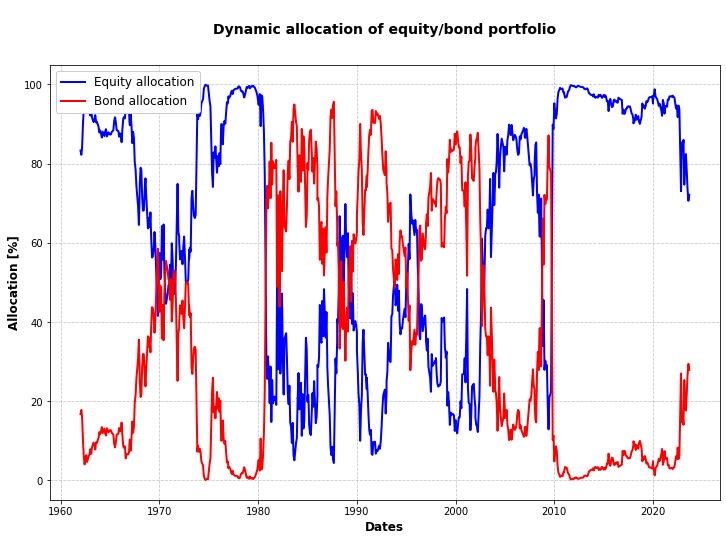

In [297]:
# Set number of months
last_months = 0

# Set dates
dates = merged_df['date'].to_numpy()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with enhanced styling
ax.plot(dates[-last_months:], alpha[-last_months:]*100, linestyle='-', color='b', linewidth=2, label="Equity allocation")
ax.plot(dates[-last_months:], (1 - alpha[-last_months:])*100, linestyle='-', color='r', linewidth=2, label="Bond allocation")

# Improve aesthetics
ax.set_xlabel('Dates', fontsize=12, fontweight='bold')
ax.set_ylabel('Allocation [%]', fontsize=12, fontweight='bold')
ax.set_title('\nDynamic allocation of equity/bond portfolio\n', fontsize=14, fontweight='bold', pad=15)

# Add legend with a styled frame
ax.legend(loc="upper left", frameon=True, fontsize=12, framealpha=1)

# Add subtle grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)

# Save figure
plt.savefig("Allocation on short time frame (third-order polynomial)")

# Show the plot
plt.show()